In [40]:
from pathlib import Path

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
FIG_DIR  = BASE_DIR / "figures"
OUT_DIR  = BASE_DIR / "outputs"

FIG_DIR.mkdir(exist_ok=True)
OUT_DIR.mkdir(exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("DATA_DIR exists?", DATA_DIR.exists())
print("DATA_DIR content:", [p.name for p in DATA_DIR.glob("*")])


BASE_DIR: /Users/emma/Desktop/Captone Project ADA
DATA_DIR exists? True
DATA_DIR content: ['ishares.xlsx', 'HFRXGL Index.xlsx', '.DS_Store', 'MSCI.xlsx', 'sp500.xlsx', 'stoxx.xlsx', 'vix.xlsx']


In [41]:
# Core
import pandas as pd
import numpy as np
from pathlib import Path

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,4)
sns.set(style="whitegrid")

# Stats / ML
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [42]:
def load_bbg_close(path, nice_name=None):
    """
    Charge un fichier Bloomberg/CapitalIQ typique :
    - Col A : Date (parfois 'Date ', 'DATE', etc.)
    - Col B : Prix (avec une ligne 'Close')
    Nettoie et renvoie une Series indexée par Date.
    """

    df = pd.read_excel(path, header=0)

    # Clean columns names (warning : HFRXGL at 'Date ')
    df.columns = [c.strip() for c in df.columns]

    # Find Date Columne
    date_col = [c for c in df.columns if 'date' in c.lower()][0]

    # Find Price Column 
    price_col = [c for c in df.columns if c != date_col][0]

    # Delete 'close' line
    df = df[df[price_col].astype(str).str.lower() != "close"]

    # Change dates
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")
    df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

    # Clean Price
    s = (
        df[price_col]
        .astype(str)
        .str.replace("\u202f", "", regex=False)
        .str.replace(" ", "", regex=False)
        .str.replace(",", ".", regex=False)
    )

    s = pd.to_numeric(s, errors="coerce").dropna()
    s.name = nice_name if nice_name else Path(path).stem.upper()

    return s

In [43]:

files = {
    "SP500":  DATA_DIR / "sp500.xlsx",
    "MSCI":   DATA_DIR / "MSCI.xlsx",
    "ISHARES": DATA_DIR / "ishares.xlsx",
    "VIX":    DATA_DIR / "vix.xlsx",
    "STOXX":  DATA_DIR / "stoxx.xlsx",
    "HFRXGL": DATA_DIR / "HFRXGL Index.xlsx",
}

raw = {
    name: load_bbg_close(path, nice_name=name)
    for name, path in files.items()
}

for name, s in raw.items():
    print(f"{name:8s} | {s.index.min().date()} → {s.index.max().date()} | {len(s)} valeurs")

SP500    | 2015-10-01 → 2025-10-01 | 121 valeurs
MSCI     | 2015-10-01 → 2025-10-01 | 121 valeurs
ISHARES  | 2015-10-01 → 2025-10-01 | 121 valeurs
VIX      | 2015-10-01 → 2025-10-01 | 121 valeurs
STOXX    | 2015-10-01 → 2025-10-01 | 121 valeurs
HFRXGL   | 2015-10-01 → 2025-10-01 | 121 valeurs


In [44]:
df_prices = pd.concat(raw.values(), axis=1)
df_prices = df_prices.sort_index()
df_prices.head()


,SP500,MSCI,ISHARES,VIX,STOXX,HFRXGL
Date,,,,,,
2015-10-01,2079.36,1705.80,107.02,15.07,375.47,1181.26
2015-11-02,2080.41,1694.40,106.40,16.13,385.43,1198.54
2015-12-01,2043.94,1662.79,105.59,18.21,365.81,1189.89
2016-01-01,NaN,1562.18,NaN,NaN,NaN,NaN
2016-01-04,1940.24,NaN,109.11,20.20,342.27,1174.07


In [45]:
df_prices.isna().sum()

SP500      15
MSCI       15
ISHARES    15
VIX        15
STOXX      15
HFRXGL     15
dtype: int64

In [46]:
df_prices[df_prices.isna().any(axis=1)]

,SP500,MSCI,ISHARES,VIX,STOXX,HFRXGL
Date,,,,,,
2016-01-01,NaN,1562.18,NaN,NaN,NaN,NaN
2016-01-04,1940.24,NaN,109.11,20.20,342.27,1174.070
2017-01-02,NaN,1792.40,NaN,NaN,360.12,NaN
2017-01-03,2278.87,NaN,105.05,11.99,NaN,1203.460
2018-01-01,NaN,2213.24,NaN,NaN,NaN,NaN
2018-01-02,2823.81,NaN,103.30,13.54,395.46,1275.600
2018-04-02,2648.05,2086.51,101.70,15.93,NaN,1262.630
2018-04-03,NaN,NaN,NaN,NaN,385.32,NaN
2018-09-03,NaN,2184.01,NaN,NaN,383.18,NaN


In [47]:
df_prices_m = df_prices.resample("M").last()
df_returns = np.log(df_prices_m / df_prices_m.shift(1)).dropna()

/var/folders/t0/1rw64m91003bt1z7lcmw0pkc0000gn/T/ipykernel_79198/2425077456.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_prices_m = df_prices.resample("M").last()


In [48]:
df_returns.tail()
df_returns.isna().sum()

SP500      0
MSCI       0
ISHARES    0
VIX        0
STOXX      0
HFRXGL     0
dtype: int64

In [49]:
df_returns.describe().T

,count,mean,std,min,25%,50%,75%,max
SP500,120.0,0.009694,0.043763,-0.133668,-0.010259,0.017714,0.035030,0.119421
MSCI,120.0,0.007677,0.042751,-0.144669,-0.014345,0.013423,0.030460,0.119175
ISHARES,120.0,-0.000823,0.019031,-0.050282,-0.011140,-0.000284,0.009492,0.041755
VIX,120.0,0.002965,0.233985,-0.614279,-0.139386,-0.001057,0.123707,0.755643
STOXX,120.0,0.003360,0.038875,-0.160149,-0.015926,0.008794,0.026851,0.128642
HFRXGL,120.0,0.002362,0.011874,-0.060616,-0.003304,0.003816,0.009150,0.028384


In [50]:
mu_annual = df_returns.mean() * 12
vol_annual = df_returns.std() * np.sqrt(12)

summary = pd.DataFrame({"mu_annual": mu_annual, "vol_annual": vol_annual})
summary

,mu_annual,vol_annual
SP500,0.116327,0.151598
MSCI,0.092127,0.148093
ISHARES,-0.009872,0.065924
VIX,0.035581,0.810549
STOXX,0.040322,0.134667
HFRXGL,0.028349,0.041131


In [51]:
corr = df_returns.corr()
corr

,SP500,MSCI,ISHARES,VIX,STOXX,HFRXGL
SP500,1.000000,0.984632,0.148552,-0.749068,0.825671,-0.136620
MSCI,0.984632,1.000000,0.164959,-0.752482,0.870638,-0.108470
ISHARES,0.148552,0.164959,1.000000,-0.052549,0.034010,-0.163474
VIX,-0.749068,-0.752482,-0.052549,1.000000,-0.664872,0.339073
STOXX,0.825671,0.870638,0.034010,-0.664872,1.000000,-0.000874
HFRXGL,-0.136620,-0.108470,-0.163474,0.339073,-0.000874,1.000000


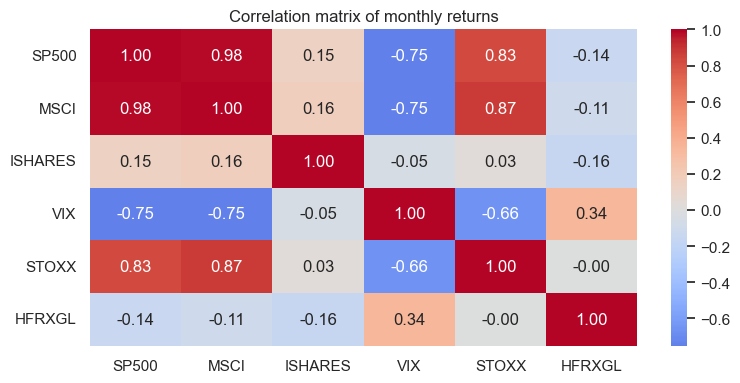

In [52]:
plt.figure()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation matrix of monthly returns")
plt.tight_layout()
plt.show()

In [53]:
from scipy.stats import pearsonr

print("Correlation between HFRXGL and market indices (full sample):\n")
for var in ["SP500", "MSCI", "STOXX", "ISHARES", "VIX"]:
    r, p = pearsonr(df_returns["HFRXGL"], df_returns[var])
    print(f"{var:7} | ρ = {r: .3f} | p-value = {p: .3g}")

Correlation between HFRXGL and market indices (full sample):

SP500   | ρ = -0.137 | p-value =  0.137
MSCI    | ρ = -0.108 | p-value =  0.238
STOXX   | ρ = -0.001 | p-value =  0.992
ISHARES | ρ = -0.163 | p-value =  0.0744
VIX     | ρ =  0.339 | p-value =  0.000152


In [54]:
# Identify the strongest and weakest correlations
corr_with_hedge = df_returns.corr()["HFRXGL"].drop("HFRXGL")

print("\nStrongest correlation:", corr_with_hedge.idxmax(), "=", corr_with_hedge.max())
print("Weakest correlation:", corr_with_hedge.idxmin(), "=", corr_with_hedge.min())


Strongest correlation: VIX = 0.33907254928910546
Weakest correlation: ISHARES = -0.16347361445304107


In [55]:
y = df_returns["HFRXGL"]
X = df_returns[["SP500", "MSCI", "STOXX", "ISHARES", "VIX"]]
X = sm.add_constant(X)

model_ols = sm.OLS(y, X).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 HFRXGL   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     7.131
Date:                Tue, 06 Jan 2026   Prob (F-statistic):           7.73e-06
Time:                        13:51:17   Log-Likelihood:                 378.57
No. Observations:                 120   AIC:                            -745.1
Df Residuals:                     114   BIC:                            -728.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.822      0.0

In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_noconst = df_returns[["SP500", "MSCI", "STOXX", "ISHARES", "VIX"]]
vif = pd.DataFrame()
vif["variable"] = X_noconst.columns
vif["VIF"] = [variance_inflation_factor(X_noconst.values, i)
              for i in range(X_noconst.shape[1])]
vif

,variable,VIF
0,SP500,39.612324
1,MSCI,54.905820
2,STOXX,5.199257
3,ISHARES,1.123053
4,VIX,2.221247


In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import TimeSeriesSplit

y = df_returns["HFRXGL"].values
X = df_returns[["SP500", "MSCI", "STOXX", "ISHARES", "VIX"]].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tscv = TimeSeriesSplit(n_splits=5)
alphas = np.logspace(-4, 4, 50)

ridge = RidgeCV(alphas=alphas, cv=tscv).fit(X_scaled, y)
lasso = LassoCV(alphas=alphas, cv=tscv, max_iter=10000).fit(X_scaled, y)

ridge_coef = pd.Series(ridge.coef_, index=["SP500","MSCI","STOXX","ISHARES","VIX"], name="Ridge")
lasso_coef = pd.Series(lasso.coef_, index=["SP500","MSCI","STOXX","ISHARES","VIX"], name="Lasso")

pd.concat([ridge_coef, lasso_coef], axis=1)

,Ridge,Lasso
SP500,-0.000608,0.000000
MSCI,0.001000,0.000000
STOXX,0.002844,0.002802
ISHARES,-0.001599,-0.001102
VIX,0.005364,0.005159


,OLS,Ridge,Lasso
SP500,-0.172389,-0.000608,0.000000
MSCI,0.220326,0.001000,0.000000
STOXX,0.075979,0.002844,0.002802
ISHARES,-0.109826,-0.001599,-0.001102
VIX,0.031269,0.005364,0.005159


<Figure size 800x500 with 0 Axes>

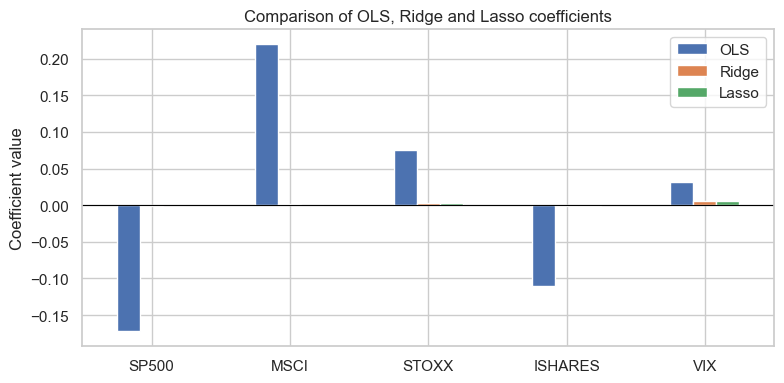

In [58]:
feature_names = ["SP500", "MSCI", "STOXX", "ISHARES", "VIX"]

# OLS Coefficients (statsmodels)
ols_coef = model_ols.params[feature_names]   

coef_df = pd.concat(
    [
        ols_coef.rename("OLS"),
        ridge_coef,
        lasso_coef
    ],
    axis=1
)

display(coef_df)

plt.figure(figsize=(8,5))
coef_df.plot(kind="bar")
plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Coefficient value")
plt.title("Comparison of OLS, Ridge and Lasso coefficients")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [59]:
 # (ME = Month End)
df_prices_m = df_prices.resample("ME").last()
df_returns = np.log(df_prices_m / df_prices_m.shift(1)).dropna()

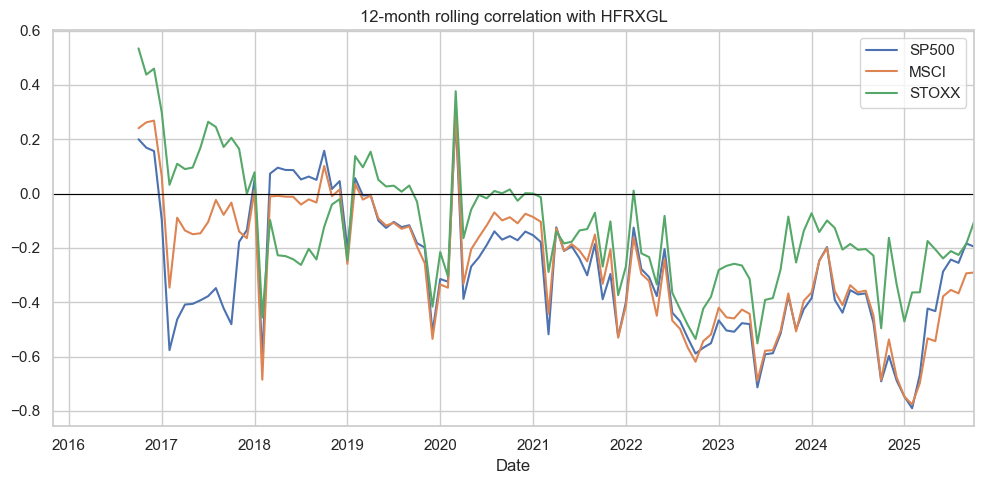

In [60]:
window = 12  # 12-month rolling window

plt.figure(figsize=(10,5))
for col in ["SP500", "MSCI", "STOXX"]:
    df_returns["HFRXGL"].rolling(window).corr(df_returns[col]).plot(label=col)

plt.axhline(0, color="black", linewidth=0.8)
plt.title(f"{window}-month rolling correlation with HFRXGL")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

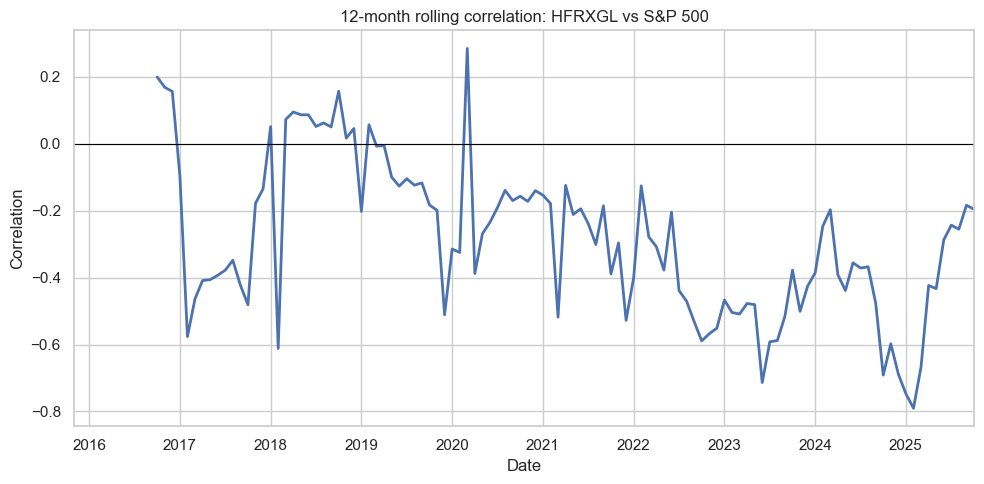

In [61]:
window = 12

plt.figure(figsize=(10,5))
df_returns["HFRXGL"].rolling(window).corr(df_returns["SP500"]).plot(linewidth=2)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("12-month rolling correlation: HFRXGL vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

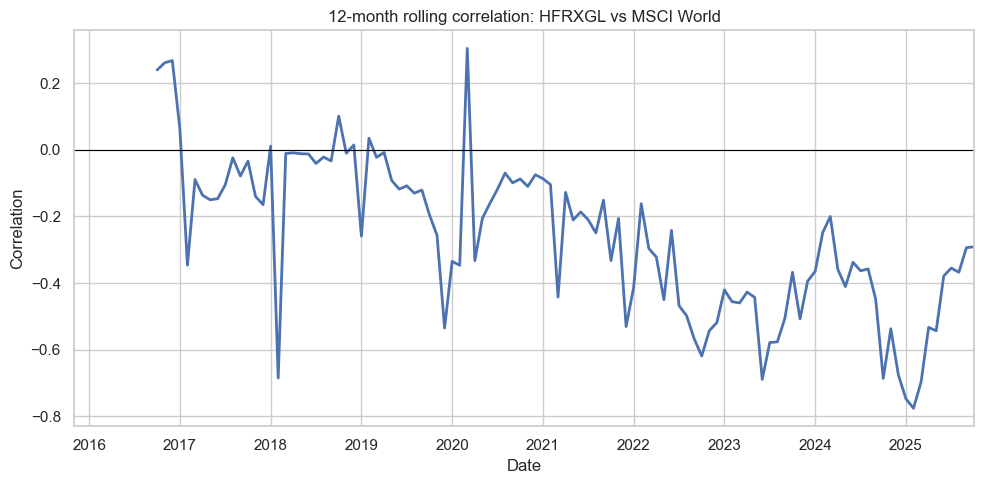

In [62]:
plt.figure(figsize=(10,5))
df_returns["HFRXGL"].rolling(window).corr(df_returns["MSCI"]).plot(linewidth=2)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("12-month rolling correlation: HFRXGL vs MSCI World")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

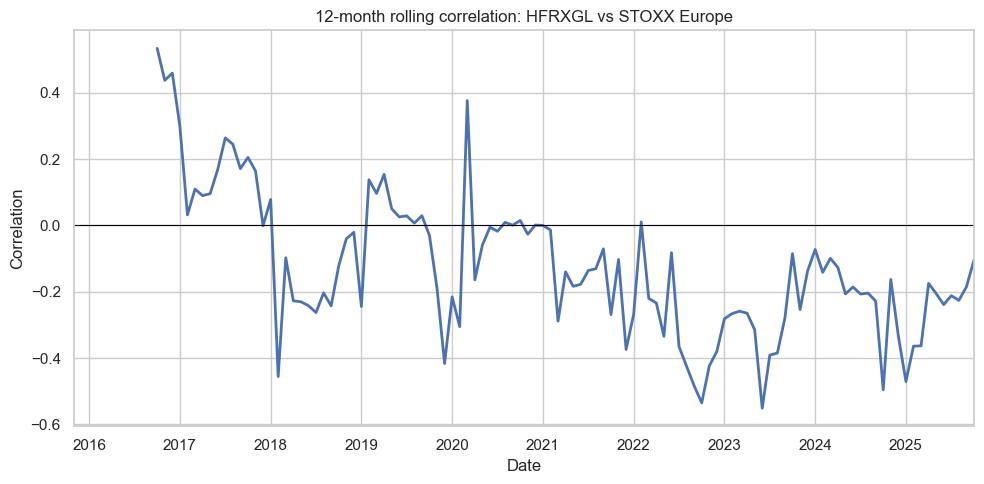

In [63]:
plt.figure(figsize=(10,5))
df_returns["HFRXGL"].rolling(window).corr(df_returns["STOXX"]).plot(linewidth=2)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("12-month rolling correlation: HFRXGL vs STOXX Europe")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

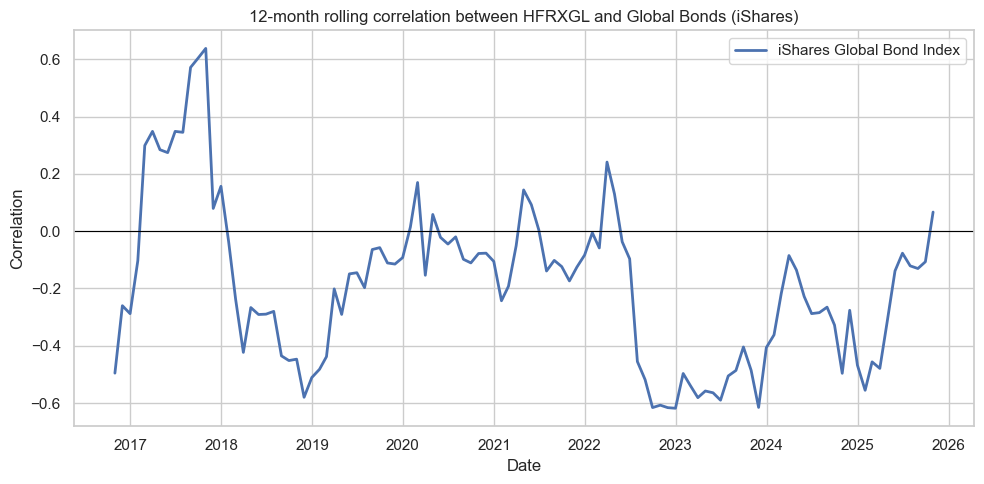

In [64]:
window = 12  # 12-month rolling window

plt.figure(figsize=(10,5))

rolling_corr_ishares = (
    df_returns["HFRXGL"]
    .rolling(window)
    .corr(df_returns["ISHARES"])
)

plt.plot(rolling_corr_ishares, linewidth=2, label="iShares Global Bond Index")
plt.axhline(0, color="black", linewidth=0.8)

plt.title("12-month rolling correlation between HFRXGL and Global Bonds (iShares)")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.tight_layout()
plt.show()

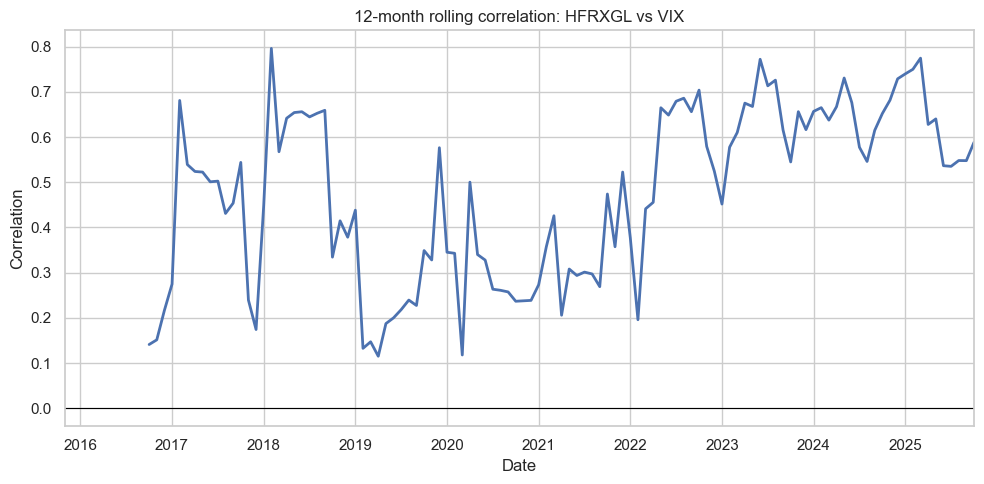

In [65]:
window = 12

plt.figure(figsize=(10,5))
df_returns["HFRXGL"].rolling(window).corr(df_returns["VIX"]).plot(linewidth=2)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("12-month rolling correlation: HFRXGL vs VIX")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

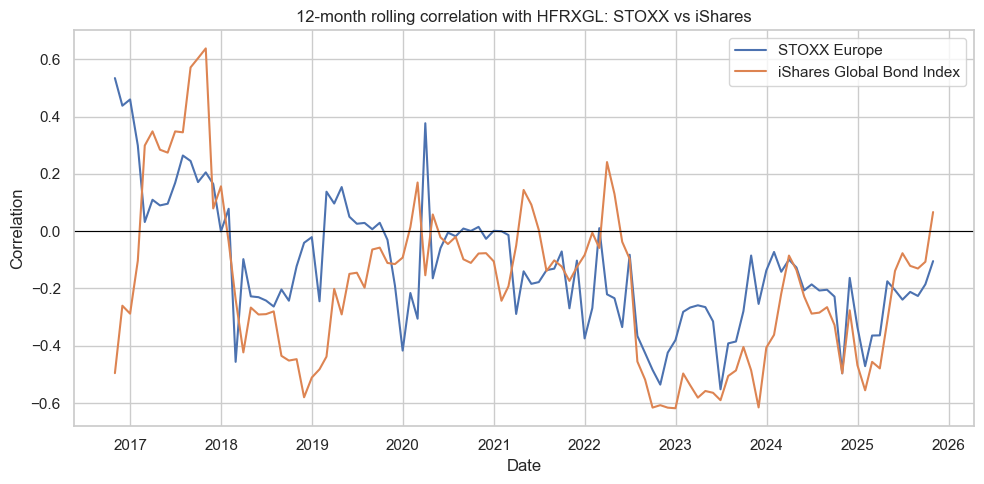

In [66]:
import matplotlib.pyplot as plt

window = 12  # 12-month rolling window

# Rolling correlations
roll_stoxx = df_returns["HFRXGL"].rolling(window).corr(df_returns["STOXX"])
roll_ishares = df_returns["HFRXGL"].rolling(window).corr(df_returns["ISHARES"])

plt.figure(figsize=(10,5))
plt.plot(roll_stoxx, label="STOXX Europe")
plt.plot(roll_ishares, label="iShares Global Bond Index")

plt.axhline(0, color="black", linewidth=0.8)
plt.title(f"{window}-month rolling correlation with HFRXGL: STOXX vs iShares")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.tight_layout()
plt.show()

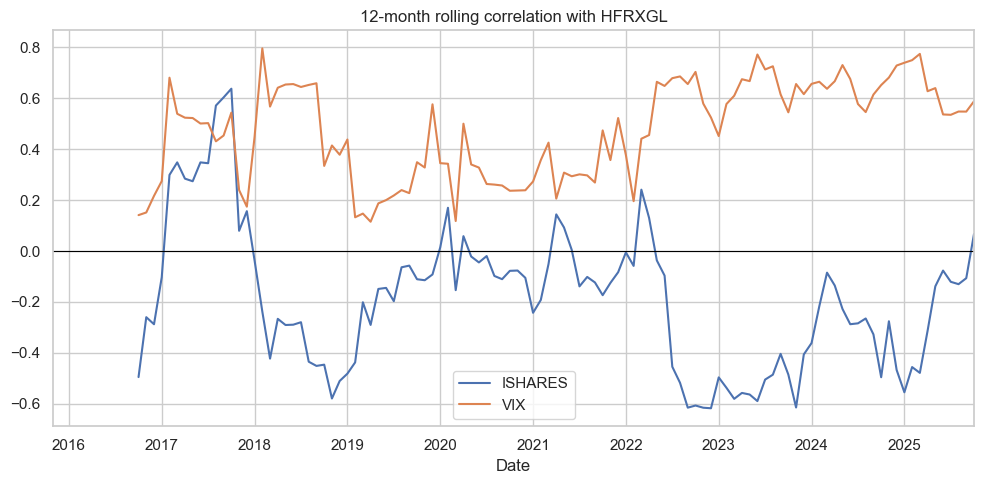

In [67]:
window = 12  # 12-month rolling window

plt.figure(figsize=(10,5))
for col in ["ISHARES", "VIX"]:
    df_returns["HFRXGL"].rolling(window).corr(df_returns[col]).plot(label=col)

plt.axhline(0, color="black", linewidth=0.8)
plt.title(f"{window}-month rolling correlation with HFRXGL")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

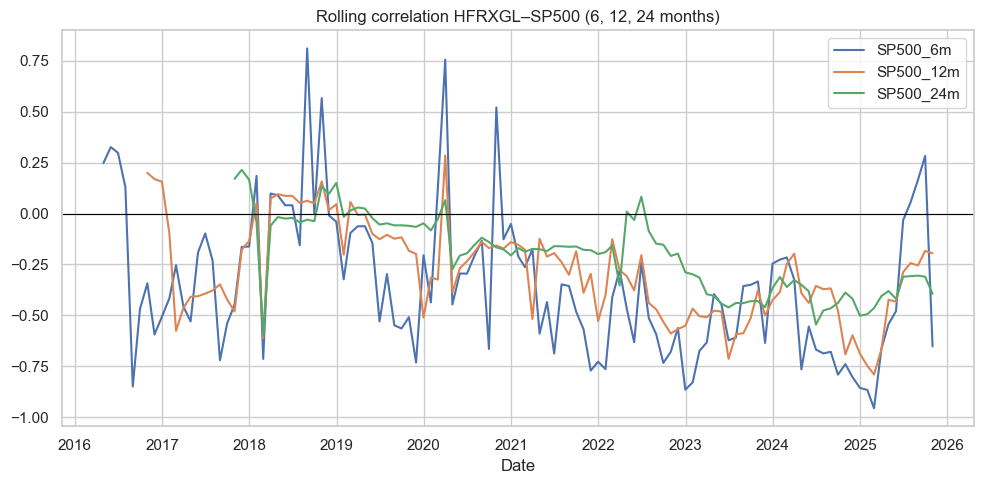

In [68]:
windows = [6, 12, 24]
corrs = {}

for w in windows:
    corrs[w] = (
        df_returns["HFRXGL"]
        .rolling(window=w)
        .corr(df_returns["SP500"])
        .rename(f"SP500_{w}m")
    )

df_corr_robust = pd.concat(corrs.values(), axis=1)

plt.figure(figsize=(10,5))
for col in df_corr_robust.columns:
    plt.plot(df_corr_robust.index, df_corr_robust[col], label=col)

plt.axhline(0, color="black", linewidth=0.8)
plt.title("Rolling correlation HFRXGL–SP500 (6, 12, 24 months)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

In [69]:
from sklearn.decomposition import PCA

X_eq = df_returns[["SP500", "MSCI", "STOXX"]]

pca = PCA()
pca.fit(X_eq)

explained = pd.Series(
    pca.explained_variance_ratio_,
    index=[f"PC{i+1}" for i in range(X_eq.shape[1])]
)
explained

PC1    0.934511
PC2    0.061434
PC3    0.004055
dtype: float64

In [70]:
PCs = pca.transform(X_eq)

df_pca = pd.DataFrame(
    PCs,
    index=df_returns.index,
    columns=[f"PC{i+1}" for i in range(X_eq.shape[1])]
)

df_pca.head()

,PC1,PC2,PC3
Date,,,
2015-11-30,-0.002675,0.027167,-0.008178
2015-12-31,-0.061145,-0.027955,0.004912
2016-01-31,-0.115809,-0.013398,-0.004316
2016-02-29,-0.033256,-0.013144,-0.000513
2016-03-31,0.070521,-0.032570,0.006601


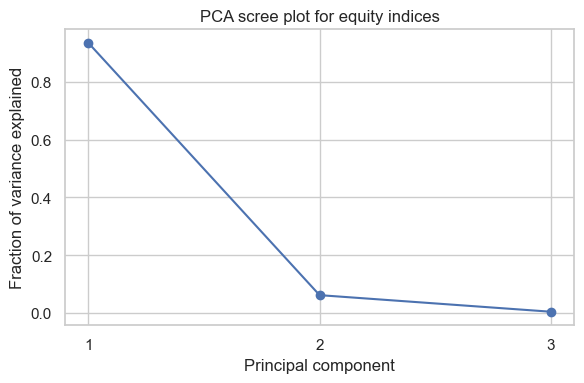

Variance explained by the first component: 0.9345111454941513


In [71]:
#  Scree plot PCA sur les indices actions 

from sklearn.decomposition import PCA

equity_cols = ["SP500", "MSCI", "STOXX"]
X_equity = df_returns[equity_cols].dropna()

pca = PCA()
pca.fit(X_equity)

expl_var = pca.explained_variance_ratio_

plt.figure(figsize=(6,4))
plt.plot(range(1, len(expl_var)+1), expl_var, marker="o")
plt.xticks(range(1, len(expl_var)+1))
plt.xlabel("Principal component")
plt.ylabel("Fraction of variance explained")
plt.title("PCA scree plot for equity indices")
plt.tight_layout()
plt.show()

print("Variance explained by the first component:", expl_var[0])

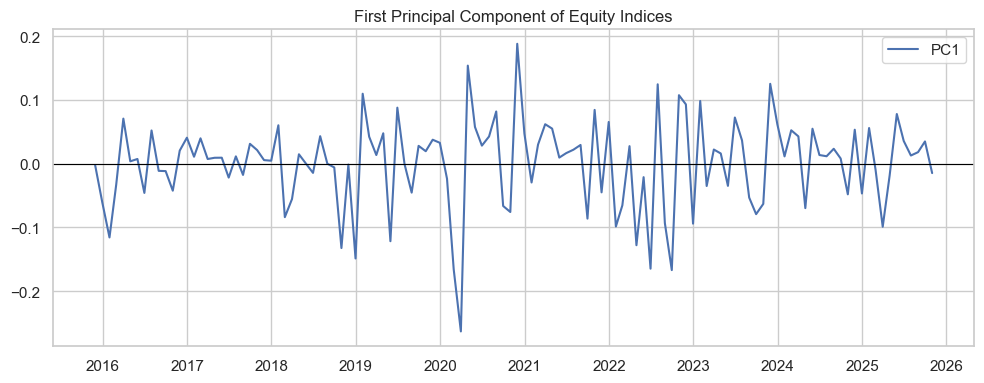

In [72]:
plt.figure(figsize=(10,4))
plt.plot(df_pca["PC1"], label="PC1")
plt.title("First Principal Component of Equity Indices")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()

In [73]:
y = df_returns["HFRXGL"]

X_factor = pd.concat(
    [
        df_pca[["PC1"]],
        df_returns[["ISHARES", "VIX"]],
    ],
    axis=1
)

X_factor = sm.add_constant(X_factor)

model_factor = sm.OLS(y, X_factor).fit()
print(model_factor.summary())

                            OLS Regression Results                            
Dep. Variable:                 HFRXGL   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     10.17
Date:                Tue, 06 Jan 2026   Prob (F-statistic):           5.34e-06
Time:                        13:51:18   Log-Likelihood:                 376.25
No. Observations:                 120   AIC:                            -744.5
Df Residuals:                     116   BIC:                            -733.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.222      0.0

In [74]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

y = df_returns["HFRXGL"].values
X = df_returns[["SP500", "MSCI", "STOXX", "ISHARES", "VIX"]].values

n = len(df_returns)
split = int(n * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---- 1) OLS sklearn
ols_skl = LinearRegression().fit(X_train, y_train)
y_pred_ols = ols_skl.predict(X_test)

# ---- 2) Ridge
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

ridge = RidgeCV(alphas=np.logspace(-4,4,50)).fit(X_train_s, y_train)
y_pred_ridge = ridge.predict(X_test_s)

# ---- 3) Lasso
lasso = LassoCV(alphas=np.logspace(-4,4,50), max_iter=50000).fit(X_train_s, y_train)
y_pred_lasso = lasso.predict(X_test_s)

def evaluate(name, y_true, y_pred):
    print(f"{name:6s} | R2 = {r2_score(y_true,y_pred): .3f} | MAE = {mean_absolute_error(y_true,y_pred): .4f}")



evaluate("OLS", y_test, y_pred_ols)
evaluate("Ridge", y_test, y_pred_ridge)
evaluate("Lasso", y_test, y_pred_lasso)

OLS    | R2 = -0.071 | MAE =  0.0057
Ridge  | R2 =  0.076 | MAE =  0.0056
Lasso  | R2 =  0.143 | MAE =  0.0054


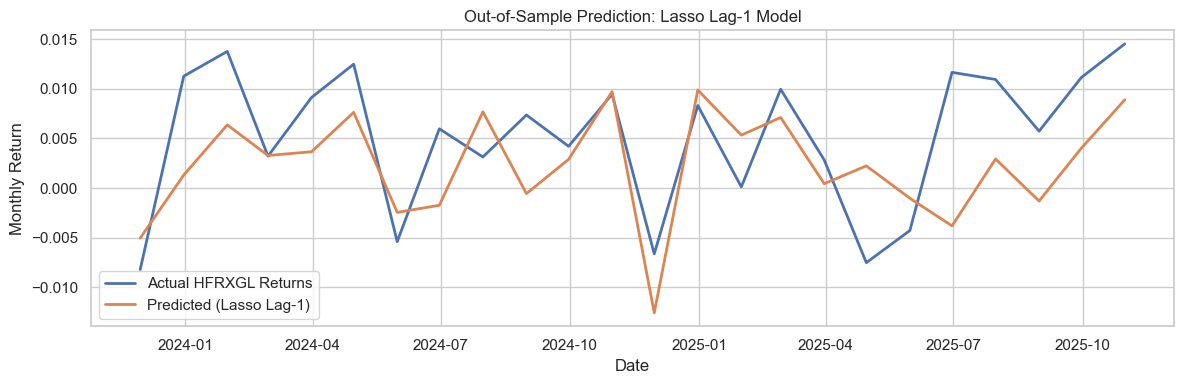

In [75]:
dates = df_returns.index

n = len(df_returns)
split = int(n * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

test_dates = dates[split:]


plt.figure(figsize=(12,4))
plt.plot(test_dates, y_test, label="Actual HFRXGL Returns", linewidth=2)
plt.plot(test_dates, y_pred_lasso, label="Predicted (Lasso Lag-1)", linewidth=2)
plt.title("Out-of-Sample Prediction: Lasso Lag-1 Model")
plt.xlabel("Date")
plt.ylabel("Monthly Return")
plt.legend()
plt.tight_layout()
plt.show()


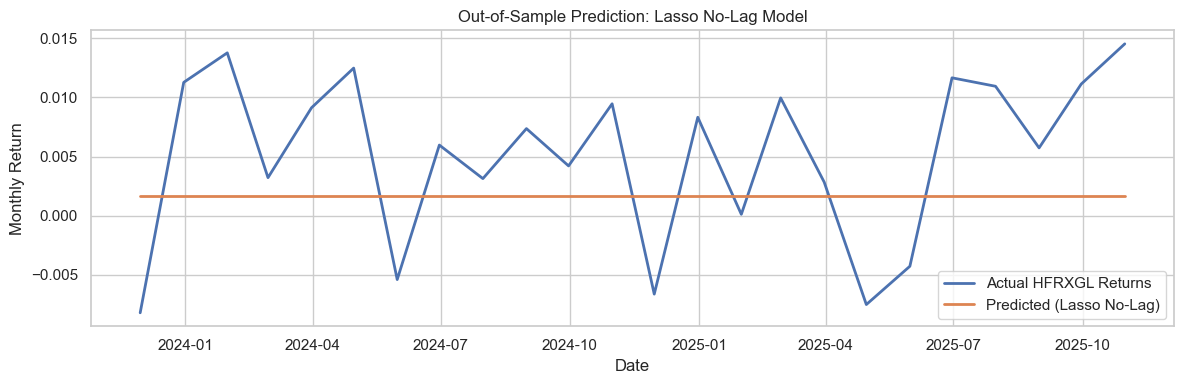

In [77]:
# ============================================================
# Out-of-Sample Prediction: Lasso (NO LAG / contemporaneous)
# Same split logic as your lag-1 block (80/20 chronological)
# ============================================================

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# 1) Build contemporaneous X, y from df_returns (robust to alignment)
feature_cols = ["SP500", "MSCI", "STOXX", "ISHARES", "VIX"]
target_col = "HFRXGL"

df_pred0 = df_returns[feature_cols + [target_col]].dropna().copy()

X0 = df_pred0[feature_cols].values
y0 = df_pred0[target_col].values
dates0 = df_pred0.index

# 2) Same 80/20 split as your lag-1 code
n0 = len(df_pred0)
split0 = int(n0 * 0.8)

X0_train, X0_test = X0[:split0], X0[split0:]
y0_train, y0_test = y0[:split0], y0[split0:]
test_dates0 = dates0[split0:]

# 3) Fit Lasso (use same alpha as your lag-1 model if you had one)
# If you already have alpha_lasso defined above, keep it; otherwise adjust this value.
alpha_lasso_0 = 0.01

scaler0 = StandardScaler()
X0_train_sc = scaler0.fit_transform(X0_train)
X0_test_sc  = scaler0.transform(X0_test)

lasso0 = Lasso(alpha=alpha_lasso_0, max_iter=10000, random_state=42)
lasso0.fit(X0_train_sc, y0_train)

y_pred_lasso_0 = lasso0.predict(X0_test_sc)

# 4) Plot (same style as your lag-1 plot)
plt.figure(figsize=(12,4))
plt.plot(test_dates0, y0_test, label="Actual HFRXGL Returns", linewidth=2)
plt.plot(test_dates0, y_pred_lasso_0, label="Predicted (Lasso No-Lag)", linewidth=2)
plt.title("Out-of-Sample Prediction: Lasso No-Lag Model")
plt.xlabel("Date")
plt.ylabel("Monthly Return")
plt.legend()
plt.tight_layout()
plt.show()


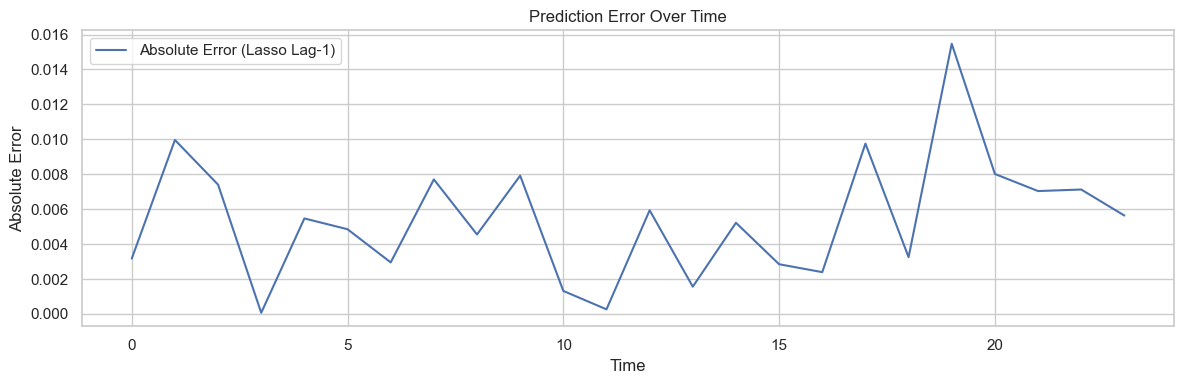

In [78]:
errors = np.abs(y_test - y_pred_lasso)

plt.figure(figsize=(12,4))
plt.plot(errors, label="Absolute Error (Lasso Lag-1)")
plt.title("Prediction Error Over Time")
plt.xlabel("Time")
plt.ylabel("Absolute Error")
plt.legend()
plt.tight_layout()
plt.show()

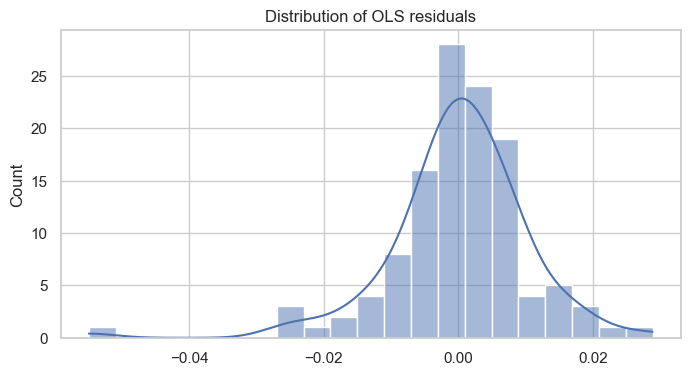

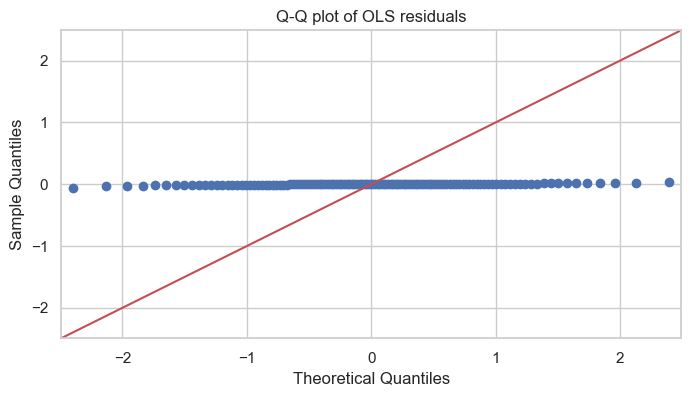

In [79]:
resid = model_ols.resid

sns.histplot(resid, kde=True)
plt.title("Distribution of OLS residuals")
plt.show()

sm.qqplot(resid, line='45')
plt.title("Q-Q plot of OLS residuals")
plt.show()

In [80]:
# Lagged predictive relationships (t-1 → t) 

df_lag = df_returns.copy()

# Variables
y_lag = df_lag["HFRXGL"]
X_lag = df_lag[["SP500", "MSCI", "STOXX", "ISHARES", "VIX"]].shift(1)

# Combine and drop NA due to lag
data_lag = pd.concat([y_lag, X_lag], axis=1).dropna()
y_lag = data_lag["HFRXGL"].values
X_lag = data_lag.drop(columns="HFRXGL").values

# Train-test split
n = len(data_lag)
split = int(n * 0.8)

X_train_l, X_test_l = X_lag[:split], X_lag[split:]
y_train_l, y_test_l = y_lag[:split], y_lag[split:]

# ---- 1) OLS (lagged)
ols_lag = LinearRegression().fit(X_train_l, y_train_l)
y_pred_ols_lag = ols_lag.predict(X_test_l)

# ---- 2) Ridge (lagged)
scaler_lag = StandardScaler()
X_train_l_s = scaler_lag.fit_transform(X_train_l)
X_test_l_s = scaler_lag.transform(X_test_l)

ridge_lag = RidgeCV(alphas=np.logspace(-4,4,50)).fit(X_train_l_s, y_train_l)
y_pred_ridge_lag = ridge_lag.predict(X_test_l_s)

# ---- 3) Lasso (lagged)
lasso_lag = LassoCV(alphas=np.logspace(-4,4,50), max_iter=50000).fit(X_train_l_s, y_train_l)
y_pred_lasso_lag = lasso_lag.predict(X_test_l_s)

# ---- Evaluation function
def evaluate(name, y_true, y_pred):
    print(f"{name:8s} | R2 = {r2_score(y_true,y_pred): .3f} | MAE = {mean_absolute_error(y_true,y_pred): .4f}")

print("\n=== Predictive performance with lag-1 variables ===")
evaluate("OLS_lag", y_test_l, y_pred_ols_lag)
evaluate("Ridge_lag", y_test_l, y_pred_ridge_lag)
evaluate("Lasso_lag", y_test_l, y_pred_lasso_lag)


=== Predictive performance with lag-1 variables ===
OLS_lag  | R2 =  0.600 | MAE =  0.0036
Ridge_lag | R2 =  0.604 | MAE =  0.0036
Lasso_lag | R2 =  0.623 | MAE =  0.0035


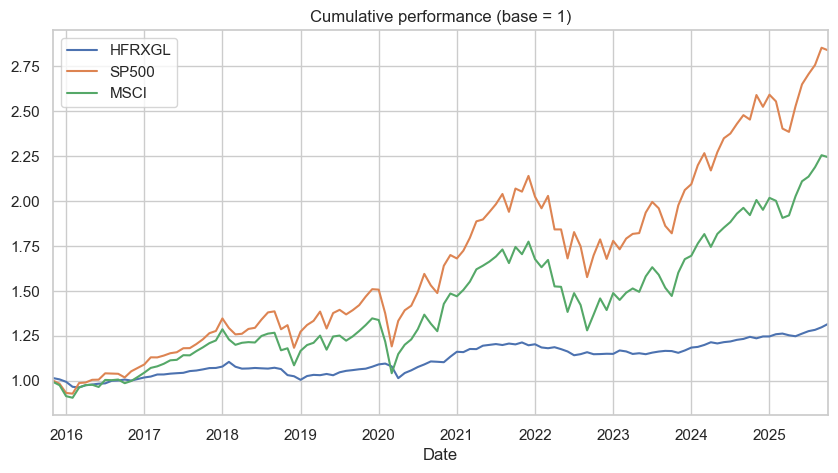

In [81]:
cum = (1 + df_returns[["HFRXGL","SP500","MSCI"]]).cumprod()

cum.plot(figsize=(10,5))
plt.title("Cumulative performance (base = 1)")
plt.show()